In [ ]:
#掛載 GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


roi (small)


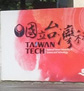

target


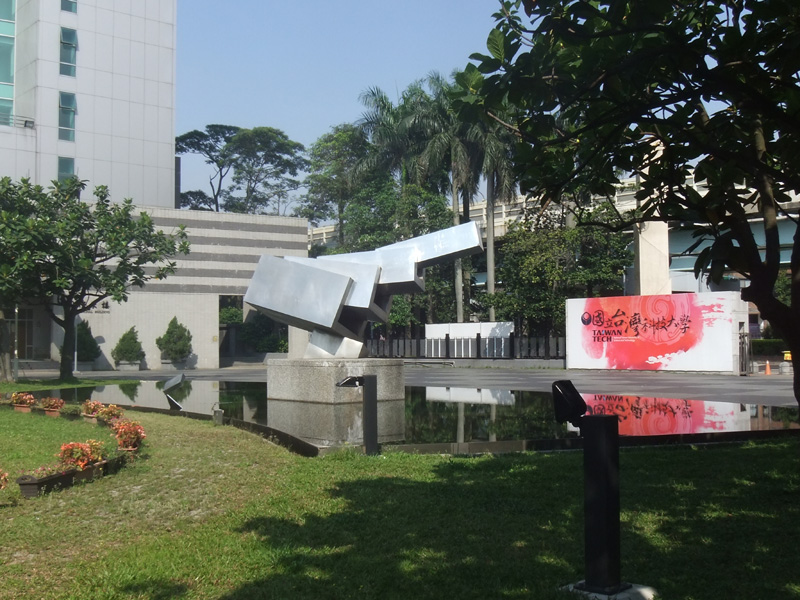

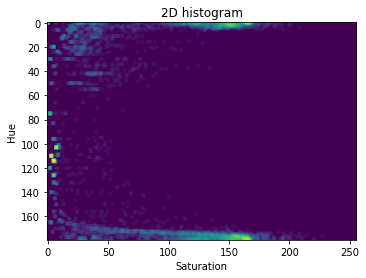

In [ ]:
'''用2D色彩分佈圖，篩選影像區域''' 
import numpy as np 
import cv2 
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt 
from matplotlib import colors as colors 
pathname = '/content/gdrive/My Drive/Colab Notebooks/'

roi = cv2.imread(pathname + 'data/c.jpg') # 色彩樣本(roi) 
print('roi (small)'), cv2_imshow(roi) # 顯示色彩樣本(roi)
hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV) # 轉換至HSV空間

target = cv2.imread(pathname + 'data/ntust.jpg') # 讀取目標影像 
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV) # 轉換至HSV空間 
print('target'), cv2_imshow(target) # 顯示目標影像 

# 計算2D色彩分佈圖(2D直方圖)
# 取hsv的[0,1]兩通道
# 垂直方向是色相H(數值0-180,間隔為1), 水平方向是飽和度S(數值0-256間隔為1)
roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )

# 將roi影像的2D色彩分佈圖拉到[0 255]的範圍
cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX) 
roihist = cv2.blur(roihist,(3, 3)) # 模糊化 
roihist = roihist+1 # 加1，避免roihist為0的地方，不能用log計算

# 由於2D色彩分佈圖的數值落差太大，使用對數影像，較能看出色彩集中的特性，
# 以下的 norm 是用來設定常態化的方式，這裡的LogNorm, 將數值取對數後，再常態化到適合的[0 1]顯示範圍
plt.imshow(roihist, norm=colors.LogNorm(), interpolation = 'bilinear') 
plt.title('2D histogram'), plt.xlabel('Saturation'), plt.ylabel('Hue') 
plt.show()

target/mask/segment


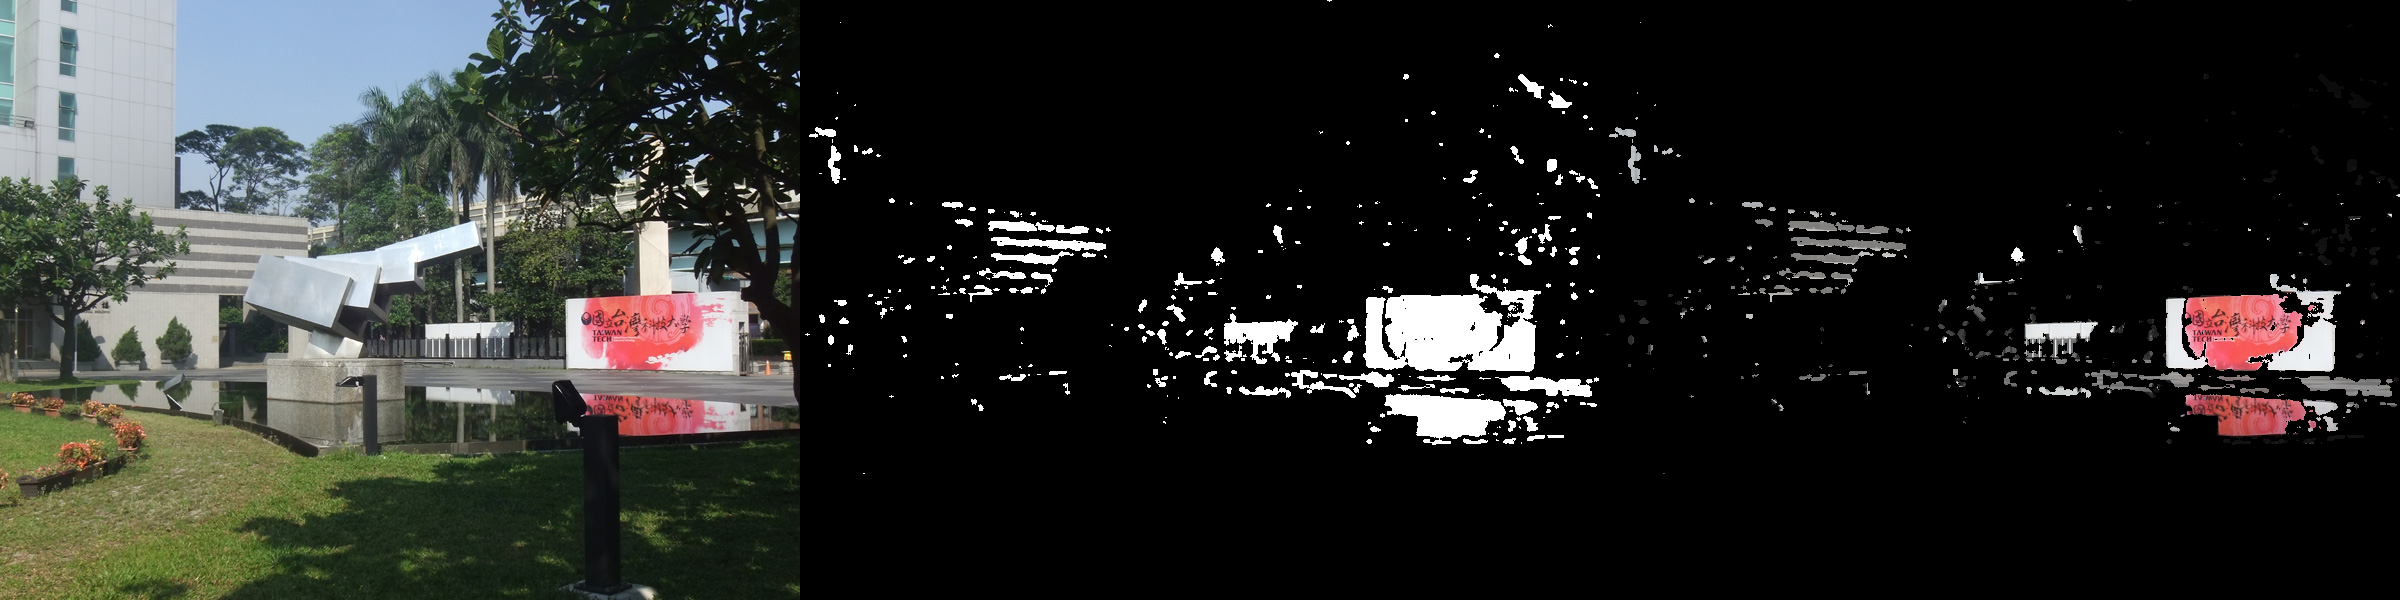

(None, None)

In [14]:
# 使用2D色彩分佈圖，計算目標影像每個像素接近此色彩分佈的機率值，獲得圖 dst
dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)
# 產生5x5大小的圓形結構元素
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
cv2.filter2D(dst,-1,disc,dst)
# 以50為門檻值，對dst做黑白二值化處理
ret,thresh = cv2.threshold(dst,50,255,0)
# 二值化的黑白影像合併成3通道的彩色影像格式，當成遮罩
mask = cv2.merge((thresh,thresh,thresh)) 
# 利用位元AND邏輯運算，res僅複製目標影像上，mask的白色的區域，也就是目標影像中，色彩與roi樣本近似的區域
res = cv2.bitwise_and(target,mask)
res = np.hstack((target,mask,res)) #三圖並排
print('target/mask/segment'), cv2_imshow(res)